# Notebook für SDM Analyse

## Load packages

In [4]:
# import standard packages
from datetime import date, datetime
import time
import math
import json
import os
from pathlib import Path
import zipfile

import ee
# import fiona
import geemap #.foliumap as geemap
import geemap.foliumap as folium
import geemap.colormaps as cm
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from pygbif import species as species
from pygbif import occurrences as occ

# import rioxarray as rxr
# import xarray as xr
# import leafmap



from toolbox.utils import *

## GEE Auth

In [5]:
ee.Authenticate()
# enter your project id here
# check google on how to set up a project
ee.Initialize(project='ee-sebasd1991')

with open('.secrets.json', 'r') as f:
    auth = json.load(f).get('GBIF')

## Parameter setup

In [ ]:
year = 2024

country_code = 'AT'
county_name = 'Tirol'

species_name = 'Lagopus muta'

limit = 2000  # for sql query.

selected_features = ['landcover', 'CHM', 'b1', 'b12', 'elevation', 'NARI', 'NCRI', 'GHMI']  # Many features might increase overfitting and take longer to retrieve from gee

### Model setup

In [7]:
model = 'Random Forest'  # Maxent, Embedding
n_trees  = 500
tree_depth = 5
train_size = .85

In [8]:
country, county = get_aoi_from_nuts(country_code='AT', county_name='Tirol')

INFO:Created 1 records
INFO:Created 1 records


## Get species Presence Points

In [ ]:
sql=f"""
SELECT species, \"year\", decimalLongitude as long, decimalLatitude as lat
FROM occurrence
WHERE countryCode = '{country_code}'
AND species = '{species_name}'
AND \"year\" >= 2024
AND hasCoordinate = TRUE
AND basisOfRecord = 'HUMAN_OBSERVATION'
LIMIT {limit}
"""
print(sql)



SELECT species, decimalLongitude as long, decimalLatitude as lat
FROM occurrence
WHERE countryCode = 'AT'
AND species = 'Lagopus muta'
AND "year" >= 2015
AND hasCoordinate = TRUE
AND basisOfRecord = 'HUMAN_OBSERVATION'
LIMIT 2000



In [10]:
response = occ.download_sql(sql=sql, user=auth["username"], pwd=auth["password"], email=auth["email"])

INFO:Your sql download key is 0009286-260208012135463


In [7]:
response = '0015176-260108223611665'

In [11]:
status_url = f"https://api.gbif.org/v1/occurrence/download/{response}"
print("Current time: ", time.strftime("%H:%M:%S"))
while True:
    r = requests.get(status_url, auth=(auth["username"], auth["password"]))
    data = r.json()
    status = data.get('status')
    if status == 'SUCCEEDED':
        print("Download ready!")
        download_url = f"https://api.gbif.org/v1/occurrence/download/request/{response}.zip"
        zip_path = f"assets/gbif_{species_name.replace(' ', '_')}.zip"
        with requests.get(download_url, auth=(auth["username"], auth["password"]), stream=True) as r:
            with open(zip_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"Download saved as {zip_path}")
        break
    elif status in ['KILLED', 'FAILED']:
        raise Exception(f" ❌ Download failed: {species_name}")
    else:
        print("Waiting for download to complete... ☕")
        time.sleep(60)
print(" ✅ Finishing time: ", time.strftime("%H:%M:%S"))


Current time:  20:32:14
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to complete... ☕
Waiting for download to co

In [12]:
with zipfile.ZipFile(zip_path, 'r') as z:
    with z.open(f"{response}.csv") as f:
        species_df = pd.read_csv(f, sep='\t', low_memory=False)
species_df = species_df.dropna(subset=['long', 'lat'])
species_df = gpd.GeoDataFrame(species_df,
                              geometry=gpd.points_from_xy(species_df['long'], species_df['lat']),
                              crs='EPSG:4326')
species_ee = geemap.gdf_to_ee(species_df)

INFO:Created 854 records


## Load all prediction layer

In [13]:
# WorldClim Bioclim
try:
    bioclim = ee.Image("projects/ee-sebasd1991/assets/BioClim")
except:
    print("Bioclim asset not found, loading history data from pubic source.")
    bioclim = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m
terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))
northness = terrain.select('aspect').multiply(math.pi/180).cos().rename('northness')
eastness = terrain.select('aspect').multiply(math.pi/180).sin().rename('eastness')

# NDVI
NDVI = (
    ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_8DAY_NDVI')
    .filterDate(f'{year}-01-01', f'{year + 1}-01-01')
    .mean()
).rename('NDVI')

HM_300M = ee.ImageCollection("projects/sat-io/open-datasets/GHM/HM_2022_300M").first().rename('GHMI')

era5 = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
        .filter(ee.Filter.date(f'{year}-01-01', f'{year + 1}-01-01'))
)
swe = era5.select(['snow_depth_water_equivalent'], ['SWE']).mean()
snow_depth = era5.select(['snow_depth'], ['snow_depth']).mean()
snow_cover = era5.select(['snow_cover'], ['snow_cover']).mean()
snow_albedo = era5.select(['snow_albedo'], ['snow_albedo']).mean()

#CLC
landcover = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select('landcover')
canopyHeight = ee.ImageCollection("projects/sat-io/open-datasets/facebook/meta-canopy-height").mosaic().rename('CHM');

nari = gee_calculate_scrub_index('nari', year).rename('NARI')
ncri = gee_calculate_scrub_index('ncri', year).rename('NCRI')

In [14]:
# Combine bands into a multi-band image
predictors = landcover.addBands(northness).addBands(eastness).addBands(NDVI).addBands(swe).addBands(snow_cover).addBands(snow_depth).addBands(terrain.select(['elevation', 'aspect', 'slope'])).addBands(canopyHeight).addBands(nari).addBands(ncri).addBands(HM_300M).addBands(bioclim)

# Create a water mask
watermask = terrain.select('elevation').gt(0)

# Mask out ocean pixels and clip to the area of interest
predictors = predictors.updateMask(watermask).clip(country)

In [15]:
background_data = load_background_data()
presence_data, predictors = get_species_features(species_df, selected_features, get_layer_information(year))

INFO:Created 854 records


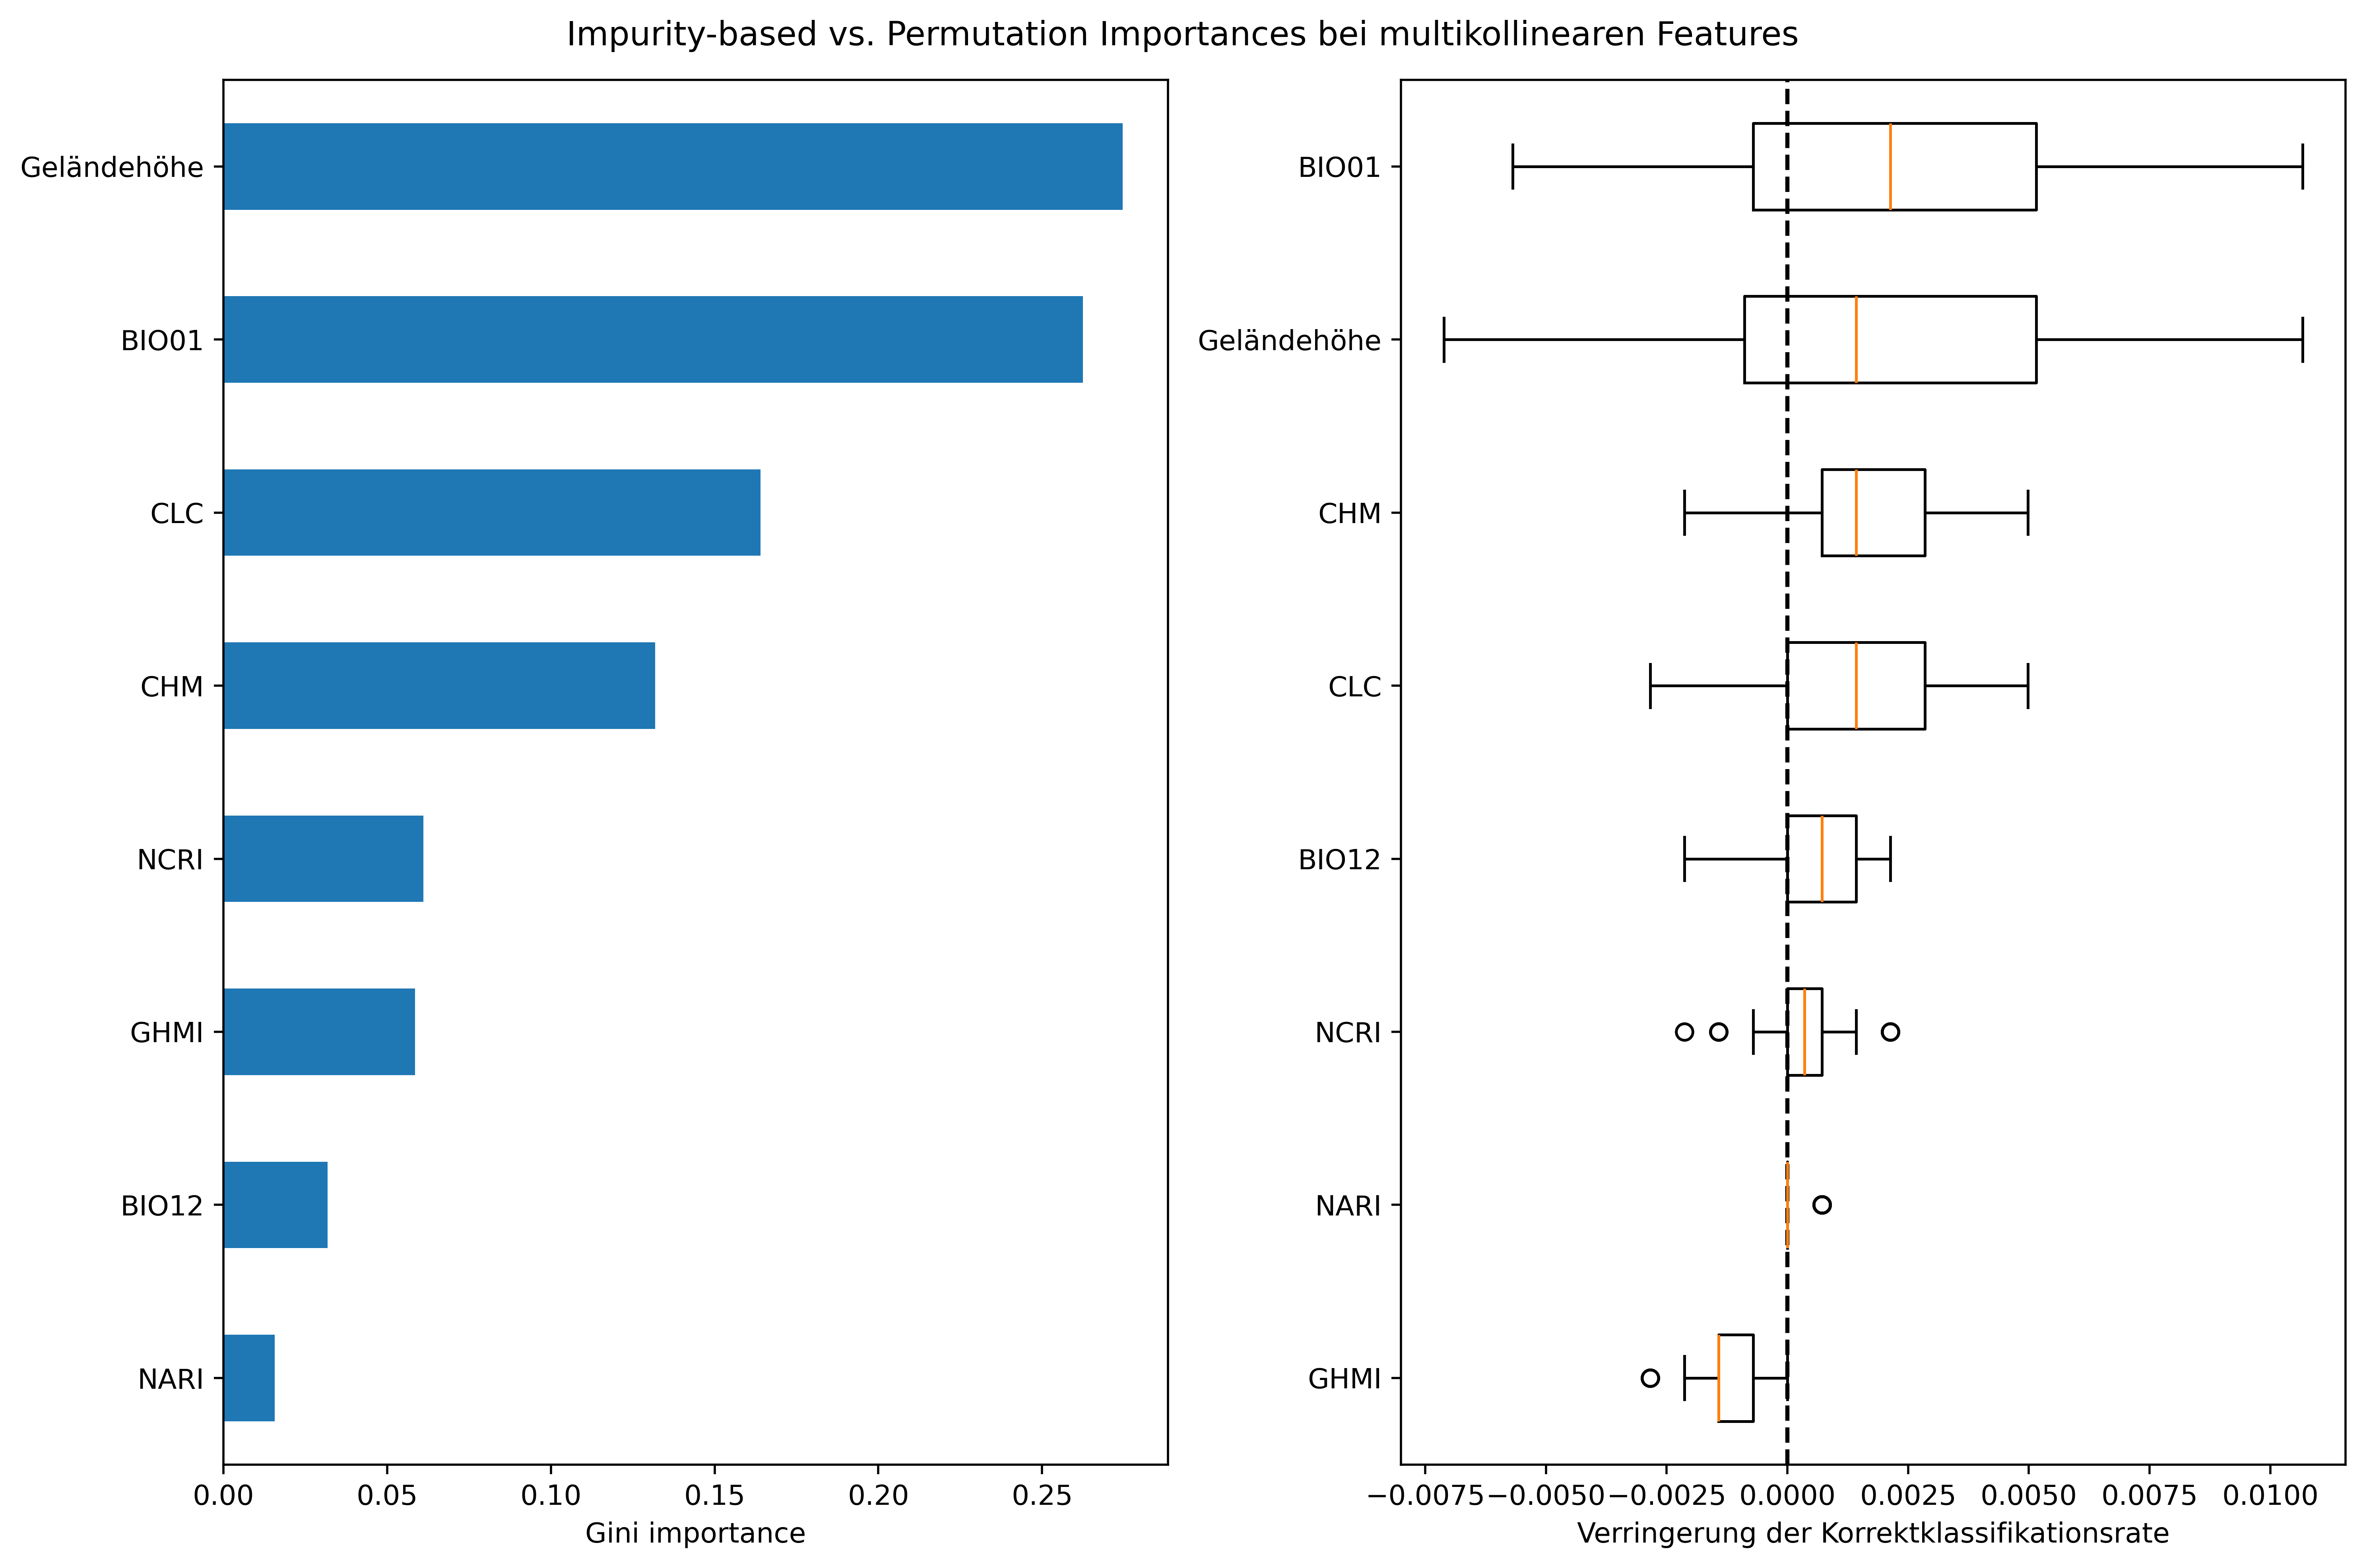

In [16]:
model, results_df, ml_gdf = compute_sdm(
                                presence=presence_data,
                                background=background_data,
                                features=list(selected_features),
                                model_type=model,
                                n_trees=n_trees,
                                tree_depth=tree_depth,
                                train_size=train_size,
                                )

In [17]:
classified_img_pr = classify_image_aoi(
                            image=predictors,
                            aoi=county,
                            ml_gdf=ml_gdf,
                            model=model,
                            features=list(selected_features)
                        )

INFO:Created 1,654 records


In [18]:
results_df

,roc_auc,landcover,CHM,b1,b12,elevation,NARI,NCRI,GHMI
0,0.940674,0.158630,0.151162,0.203481,0.076422,0.250557,0.004634,0.077285,0.077829
1,0.956158,0.188674,0.149508,0.247403,0.031388,0.228717,0.005547,0.085004,0.063757
2,0.939188,0.149745,0.144660,0.289574,0.044362,0.228113,0.002829,0.068981,0.071736
3,0.937317,0.164576,0.194511,0.218989,0.035596,0.218248,0.010552,0.094267,0.063261
4,0.939119,0.195633,0.137836,0.267172,0.081219,0.208717,0.003424,0.044617,0.061380
5,0.947366,0.159218,0.138514,0.264607,0.037392,0.245576,0.016449,0.102342,0.035902
6,0.947971,0.162431,0.147934,0.226623,0.094956,0.214468,0.004689,0.101412,0.047487
7,0.946495,0.147013,0.153076,0.260653,0.087458,0.231333,0.005429,0.036843,0.078195
8,0.944718,0.219661,0.121348,0.244295,0.060458,0.197363,0.007682,0.068688,0.080504
9,0.935851,0.164019,0.131809,0.262487,0.031845,0.274640,0.015663,0.061058,0.058479


## Show map

In [19]:
Map = geemap.Map()
Map.add_basemap("SATELLITE")

Map.addLayer(classified_img_pr, {'min': 0, 'max': 1, 'palette': geemap.colormaps.palettes.viridis_r}, 'Classified Image', opacity=.7)
Map.addLayer(species_ee, {'color':'red'}, 'POI')
Map.add_colorbar({'min': 0, 'max': 1, 'palette': geemap.colormaps.palettes.viridis_r}, label="Habitat suitability",
                orientation="horizontal",
                position="bottomright",
                layer_name="Habitat suitability")
Map.centerObject(country)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [21]:
type(Map)

geemap.geemap.Map

## Various summary stats

In [22]:
threshold= classified_img_pr.reduceRegion(
    reducer=ee.Reducer.percentile([10]),
    geometry=species_ee,
    scale=30,
    maxPixels=1e13
).getInfo()['classification']
print(threshold)

0.6936281888402989


In [23]:
(classified_img_pr.gte(threshold)).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=county,
    scale=30,
    maxPixels=1e13
).getInfo()

{'classification': 0.4242135265147319}

In [31]:
canopyHeight.reduceRegion(
    reducer=ee.Reducer.median(),
    geometry=species_ee,
    scale=30,
    maxPixels=1e13
).getInfo()

{'CHM': 0}

In [32]:
terrain.select('elevation').updateMask(classified_img_pr.gte(threshold)).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=county,
    scale=30,
    maxPixels=1e13
).getInfo()

{'elevation': 2335.53899852467}

## Export classified image

In [44]:
task = ee.batch.Export.image.toDrive(
    image = classified_img_pr,
    description=f'sdm_{species_name.replace(' ', '_')}_{county_name}_{datetime.now().date().strftime("%Y_%m_%d")}',
    # assetId='projects/ee-sebasd1991/assets/sdm/sdm_rf_20251220_1',
    scale=10,
    region=county.geometry().bounds(),
    fileFormat='GeoTIFF',
    crs='EPSG:3857',
    maxPixels=1e13,
    formatOptions={'noData': 0},

)
task.start()

In [ ]:
while True:
    status = task.status()['state']
    match status:
        case 'RUNNING':
            print('Still running ... ☕')
            time.sleep(60)
        case 'COMPLETE':
            print(' ✅ Check your Google - Drive')
            break

Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕
Still running ... ☕


In [47]:
task.status()

{'state': 'RUNNING',
 'description': 'sdm_Lagopus_muta_Tirol_2026_01_16',
 'priority': 100,
 'creation_timestamp_ms': 1768594033292,
 'update_timestamp_ms': 1768594151635,
 'start_timestamp_ms': 1768594047850,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'F6QNDXXJKYGLY4OJSMIBBLGJ',
 'name': 'projects/ee-sebasd1991/operations/F6QNDXXJKYGLY4OJSMIBBLGJ'}